In [1]:
import json
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(rc={'figure.figsize':(15,6)})
from tqdm import tqdm

### Доверительный интервал и правило 2 сигм

In [2]:
def get_bernoulli_confidence_interval(values: np.array):
    """Вычисляет доверительный интервал для параметра распределения Бернулли.

    :param values: массив элементов из нулей и единиц.
    :return (left_bound, right_bound): границы доверительного интервала.
    """
    
    n = len(values)
    z = 1.96
    p = np.mean(values)
    sigma = np.sqrt(p * (1-p))
    
    interval = z * sigma / np.sqrt(n)
    
    return (np.clip(p - interval, 0, 1), np.clip(p + interval, 0, 1))

#### Сгенерируем случайную выборку со средним 0,5 и средним отклонением 0,1

In [3]:
sample_values = np.random.normal(0.5, 0.1, 100)

#### Посчитаем доверительный интервал и интервал 2-сигма

In [4]:
get_bernoulli_confidence_interval(sample_values)

(0.40247187918892774, 0.5984717919184228)

In [5]:
(np.quantile(sample_values, 0.025), np.quantile(sample_values, 0.975))

(0.29447053466659573, 0.6902666341785465)

#### Увеличим размер выборки до 1000

In [6]:
sample_values = np.random.normal(0.5, 0.1, 1000)

#### Посчитаем доверительный интервал и интервал 2-сигма

In [7]:
get_bernoulli_confidence_interval(sample_values)

(0.4662340562700031, 0.5282137430654136)

In [8]:
(np.quantile(sample_values, 0.025), np.quantile(sample_values, 0.975))

(0.2852905028487003, 0.6952089003632884)

#### Видим, что доверительный интервал стал намного меньше, интервал 2-сигм не изменился

### Статистические критерии

In [9]:
np.random.seed(33)

#### Сгенерируем датафрейм и искусственно добавим эффект, то есть представим, что в тестовой группе выросла метрика

In [10]:
df = pd.DataFrame({
    'control' : np.random.normal(100, 10, 1000),
    'test' : np.random.normal(100, 10, 1000) + np.random.normal(2, 5, 1000)
})

In [11]:
df.head()

,control,test
0,96.811465,104.381927
1,83.970194,83.438401
2,84.647821,110.738778
3,94.295991,88.536662
4,97.832717,109.172851


#### Тест Стьюдента

In [12]:
ttest_ind(df['test'].values, df['control'].values)

Ttest_indResult(statistic=4.682024894343122, pvalue=3.0314908440032458e-06)

#### P-value < 0.05, гипотеза о равенстве отвергается

#### Бутстрэп

In [13]:
np.random.seed(0)

In [14]:
n_iter = 1000
mean_diff_list = []

number_obs = len(df)

for i in range(n_iter):
    # Генерируем выборку с повторениями
    df_sample = df.sample(number_obs, replace = True)
    mean_control = df_sample['control'].mean()
    mean_test = df_sample['test'].mean()
    mean_diff = mean_test - mean_control
    mean_diff_list.append(mean_diff)

In [15]:
mean_diff_df = pd.DataFrame(mean_diff_list, columns = ['mean_diff'])

In [16]:
(mean_diff_df.quantile(0.025), mean_diff_df.quantile(0.975))

(mean_diff    1.224659
 Name: 0.025, dtype: float64,
 mean_diff    3.059107
 Name: 0.975, dtype: float64)

0 не входит в диапазон (1,29, 3,08), поэтому гипотеза о равенстве средних также отвергается

### Размер выборки

In [17]:
alpha = 0.05
beta = 0.2
conversion = 0.4

In [18]:
def estimate_sample_size_classification(mean_target, effects, alpha = 0.05, beta = 0.2):
    """Оцениваем sample size для списка эффектов.

    mean_target - str, средний таргет на исторических данных
    effects - List[float], список ожидаемых новых конверсий. Например, [0.03] - увеличение на 3%
    alpha - float, ошибка первого рода
    beta - float, ошибка второго рода

    return - pd.DataFrame со столбцами ['effect', 'sample_size']    
    """
    
    t_alpha = norm.ppf(1 - alpha / 2, loc = 0, scale = 1)
    t_beta = norm.ppf(1 - beta, loc = 0, scale = 1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    std_control = mean_target * (1 - mean_target)
    sample_sizes = list()
    
    for effect in effects:
        mean_target_test = mean_target + effect
        std_test = mean_target_test * (1 - mean_target_test)
        std = std_test + std_control
        sample_size = int(
            np.ceil(
                z_scores_sum_squared * std / (effect ** 2)
            )
        )
        sample_sizes.append(sample_size)
        
    sample_size_df = pd.DataFrame({
        'effect': effects,  
        'sample_size': sample_sizes
    })
    sample_size_df = sample_size_df.round(2)
    
    return sample_size_df

In [19]:
sample_size_df = estimate_sample_size_classification(
    mean_target = conversion, 
    effects = [i for i in np.arange(0.03, 0.21, 0.01)],
    alpha = alpha,
    beta = beta
)

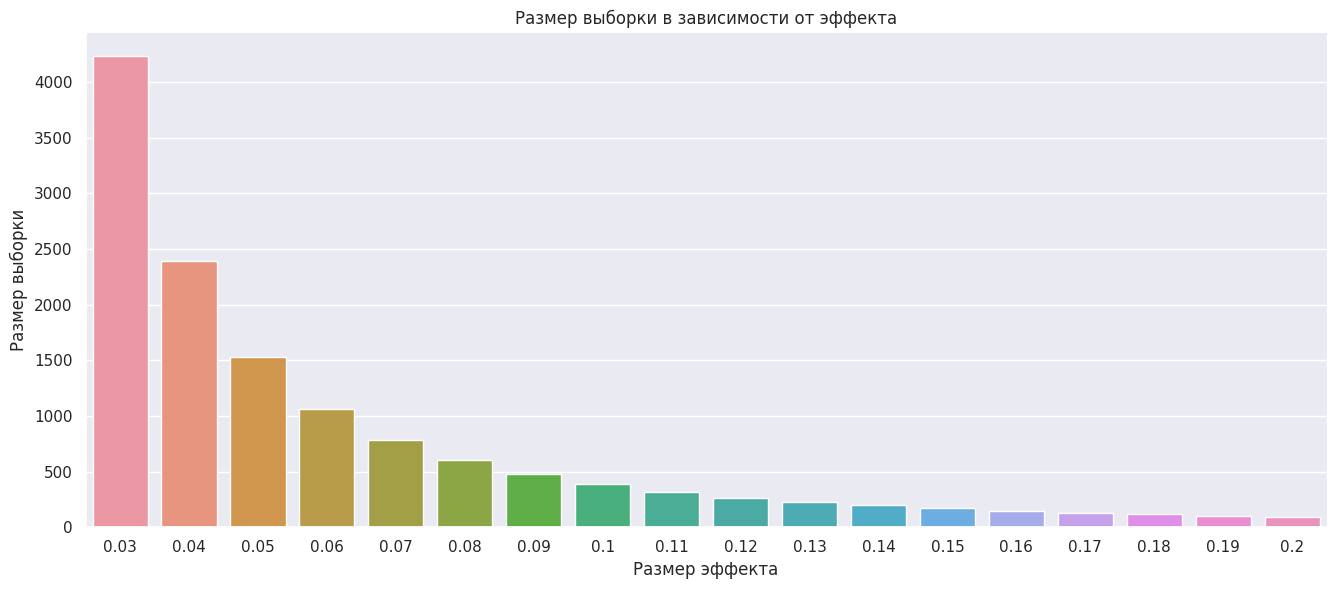

In [20]:
figure = sns.catplot(
    data = sample_size_df,
    x = 'effect',
    y = 'sample_size',
    kind = 'bar',
    legend_out = False
).set(title = 'Размер выборки в зависимости от эффекта');

figure.fig.set_size_inches(16, 6)
figure.set(xlabel = 'Размер эффекта', ylabel = 'Размер выборки');

### Стратификация

In [21]:
df = pd.read_csv('data_stratification.csv', encoding='windows-1251', header = 0)

In [22]:
df['group'].value_counts()

pilot      1000
control    1000
Name: group, dtype: int64

посмотрим на распределение целевой переменной в группах.
поскольку в данных много нулей, то имеет смысл отдельно нарисовать распределение для нулевых значений и для ненулевых значений.

определим для этого отдельную функцию.

In [23]:
def plot_hist_for_zero_and_nonzero_values(df, feature, group):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sns.histplot(df[df[feature] == 0], ax=ax1, x=feature, hue=group, multiple='dodge', legend=False)
    ax1.set_xticks([0])
    sns.histplot(df[df[feature] != 0], ax=ax2, x=feature, hue=group, multiple='dodge')

plot_hist_for_zero_and_nonzero_values(df, 'inapp', 'group')

В обоих группах много нулей, в пилотной покупок чуть больше.

Посчитаем среднее значение и другие статистики. Проверим статистическую значимость.

In [24]:
df.groupby('group').agg(
    inapp_mean = pd.NamedAgg(column = 'inapp', aggfunc = 'mean'),    
    inapp_std = pd.NamedAgg(column = 'inapp', aggfunc = 'std'),    
    inapp_sum = pd.NamedAgg(column = 'inapp', aggfunc = 'sum'),    
)

,inapp_mean,inapp_std,inapp_sum
group,,,
control,5.01,20.253644,5010
pilot,7.36,25.057100,7360


In [25]:
inapp_pilot = df[df['group'] == 'pilot']['inapp'].values
inapp_control = df[df['group'] == 'control']['inapp'].values

stats.ttest_ind(inapp_pilot, inapp_control)

Ttest_indResult(statistic=2.3065075655928977, pvalue=0.021184160406364526)

pvalue меньше 0.05, гипотеза о равенстве средних отвергается на уровне значимости 0.05.

**НО** мы ничего не знаем о том, как подбирались эти группы и какие ошибки первого и второго рода могут быть на этих данных. Давайте посмотрим на другие признаки в датасете.

In [26]:
df_agg_ = (
    df.groupby(['group', 'ОС'])[['inapp']].count()
    .rename(columns = {'inapp': 'count'}).reset_index()
)
sns.barplot(x = 'ОС', y = 'count', hue = 'group', data = df_agg_)

sns.displot(df, x = 'age', hue = 'group', multiple = 'dodge')

sns.displot(df, x = 'inapp_prev_week', hue = 'group', multiple = 'dodge');

#### Введем переменную - флаг была ли хоть одна покупка на предыдущей неделе

In [27]:
df['strat'] = (df['inapp_prev_week'] > 0).astype(int)

In [28]:
df_stat = df.groupby(['group','strat'], as_index = False)['age'].agg(['count'])
df_stat['percent'] = df_stat['count'] / 1000

In [29]:
df_stat

count  percent
group   strat                
control 0        963    0.963
        1         37    0.037
pilot   0        938    0.938
        1         62    0.062

Отличия по ОС малы, возраст тоже довольно равномерно распределён. А вот покупки на неделе до пилота, как и покупки во время пилота, содержат много нулей и в пилотной группе покупок больше.

Давайте сделаем постстратификацию. Стратифицируем данные по наличию покупок до пилота.

In [30]:
def calc_strat_mean(df: pd.DataFrame, strat_column: str, target_name: str, weights: dict):
    """Считаем стратифицированное среднее.
    
    df - датафрейм с целевой метрикой и данными для стратификации
    strat_column - названия столбца по которому проводить стратификацию
    target_name - название столбца с целевой переменной
    weights - словарь - {название страты: вес страты}
    
    return: float, mean_strat
    """
    strat_mean = df.groupby(strat_column)[target_name].mean()
    return (strat_mean * pd.Series(weights)).sum()

In [31]:
strat_weights = df['strat'].value_counts() / df['strat'].count()

df_pilot = df[df['group'] == 'pilot'].copy()
df_control = df[df['group'] == 'control'].copy()

mean_strat_pilot = calc_strat_mean(df_pilot, 'strat', 'inapp', strat_weights)
mean_strat_control = calc_strat_mean(df_control, 'strat', 'inapp', strat_weights)

print('Стратифицированное среднее')
print(f'Тестовая группа: {mean_strat_pilot:0.3f} Контрольная группа: {mean_strat_control:0.3f}')
print(f'Разность {mean_strat_pilot - mean_strat_control:0.3f}')

print('\n Простое среднее')
print(f'Тестовая группа: {inapp_pilot.mean():0.3f} Контрольная группа: {inapp_control.mean():0.3f}')
print(f'Разность {inapp_pilot.mean() - inapp_control.mean():0.3f}')

Стратифицированное среднее
Тестовая группа: 6.390 Контрольная группа: 5.861
Разность 0.529

 Простое среднее
Тестовая группа: 7.360 Контрольная группа: 5.010
Разность 2.350


Отличие уменьшилось с 2.35 до 0.53.

Оценим значимость эффекта, построив доверительный интервал с помощью бутстрепа.

In [32]:
alpha = 0.05
group_size = df_pilot.shape[0]
n_iter = 2000

def stratified_bootstrap(df: pd.DataFrame, strat_column: str, group_size):
    df_size = len(df_pilot.index)
    indices_list = []
    for group_index in set(df[strat_column].values):
        indices = df[df[strat_column] == group_index].index
        indices_list.append(np.random.choice(indices, int(group_size * len(indices) / df_size)))
    return df.loc[np.concatenate(indices_list)]

list_diff_strat_mean = []
for _ in range(n_iter):
    sample_df_pilot = stratified_bootstrap(df_pilot, 'strat', df_pilot.shape[0])
    sample_df_control = stratified_bootstrap(df_control, 'strat', df_control.shape[0])

    mean_strat_sample_pilot = calc_strat_mean(sample_df_pilot, 'strat', 'inapp', strat_weights)
    mean_strat_sample_control = calc_strat_mean(sample_df_control, 'strat', 'inapp', strat_weights)

    list_diff_strat_mean.append(mean_strat_sample_pilot - mean_strat_sample_control)


list_diff_mean = []
for _ in range(n_iter):
    sample_pilot_indexes = np.random.choice(np.arange(group_size), group_size)
    sample_control_indexes = np.random.choice(np.arange(group_size), group_size)
    sample_df_pilot = df_pilot.iloc[sample_pilot_indexes]
    sample_df_control = df_control.iloc[sample_control_indexes]

    list_diff_mean.append(sample_df_pilot['inapp'].mean() - sample_df_control['inapp'].mean())

left_bound_strat_mean = np.quantile(list_diff_strat_mean, alpha / 2)
right_bound_strat_mean = np.quantile(list_diff_strat_mean, 1 - alpha / 2)
left_bound_mean = np.quantile(list_diff_mean, alpha / 2)
right_bound_mean = np.quantile(list_diff_mean, 1 - alpha / 2)

print(f'confidence interval strat mean: ({left_bound_strat_mean:0.3f}, {right_bound_strat_mean:0.3f})')
print(f'confidence interval mean: ({left_bound_mean:0.3f}, {right_bound_mean:0.3f})')

confidence interval strat mean: (-0.931, 1.915)
confidence interval mean: (0.220, 4.400)


Бутстреп подтверждает наличие эффекта при вычислении обычного среднего.

Для стратифицированного среднего данные нулевой гипотезе о равенстве средних не противоречат, ноль лежит внутри 95%
доверительного интервала. Это повод провести эксперимент повторно, уделив больше внимания его изначальному дизайну.

### CUPED

#### Посмотрим на примере как с помощью CUPED можно снизить дисперсию в данных и получить более чувствительный тест

#### Сгенерируем случайные данные

In [33]:
group_size = 2000
np.random.seed(33)

In [34]:
df = pd.DataFrame({
    'y_test_before': np.random.normal(120, 40, group_size),
    'y_control_before': np.random.normal(120, 40, group_size)
})

df['y_test'] = df['y_test_before'] + np.random.normal(0, 10, group_size)
df['y_control'] = df['y_control_before'] + np.random.normal(0, 10, group_size)

#### Искусственно добавим эффект, то есть представим, что во время пилота выросла метрика в тестовой группе

In [35]:
df['y_test'] += np.random.normal(1, 2, group_size)

In [36]:
df.head()

,y_test_before,y_control_before,y_test,y_control
0,107.245860,158.824619,121.193572,162.383391
1,55.880778,42.041195,57.082363,58.883040
2,58.591285,180.677089,56.959718,174.232989
3,97.183964,159.266027,74.451601,157.609703
4,111.330868,106.441095,114.010630,123.663425


In [37]:
df.mean()

y_test_before       119.989725
y_control_before    120.813658
y_test              120.846757
y_control           120.998000
dtype: float64

In [38]:
_, pvalue_pilot = ttest_ind(df['y_test'], df['y_control'])
print(f'pvalue pilot {pvalue_pilot:0.3f}')

pvalue pilot 0.908


### Pvalue > 0.05, гипотеза не отвергается

In [39]:
def calculate_theta(y_control, y_pilot, y_control_cov, y_pilot_cov) -> float:
    """Вычисляем Theta.
    
    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    y_control_cov - значения ковариант на контрольной группе
    y_pilot_cov - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    y_cov = np.hstack([y_control_cov, y_pilot_cov])
    covariance = np.cov(y_cov, y)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return theta

In [40]:
theta = calculate_theta(
    df['y_control'], df['y_test'],
    df['y_control_before'], df['y_test_before']
)

df['y_test_cuped'] = df['y_test'] - theta * df['y_test_before']
df['y_control_cuped'] = df['y_control'] - theta * df['y_control_before']

In [41]:
_, pvalue_cuped = ttest_ind(df['y_test_cuped'], df['y_control_cuped'])
print(f'pvalue cuped {pvalue_cuped:0.3f}')

pvalue cuped 0.036


### Pvalue < 0.05, гипотеза отвергается